In [1]:
import os
import json

from sklearn.model_selection import GridSearchCV, ParameterGrid
from multiprocessing import Pool
import multiprocessing

import pickle
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

%matplotlib notebook
sns.set_style("whitegrid")
rc('text', usetex=True)

# Example Grid Search Using Multiprocessing

In [2]:
def single(config, path_to_bin="./thrax.bin", config_base_path="./config/tmp"):
    # create temporary config file
    name = "config-" + str(multiprocessing.current_process().name[-2:]) + ".json.tmp"
    config_path = os.path.join(config_base_path, name)
    with open(config_path, 'w') as f:
        json.dump(config, f)
    # run with config
    _ = !{path_to_bin + " -c " + config_path}
    print("done")
    return True

def gridsearch(config_template, parameter_grid, num_processes, map_function, filter_function=None, run=True):
    """
        config_template: default config
        parameter_grid: parameter grid to be tested
        num_processes: number of processes
        map_function: function that maps config_template and a single entry of parameter grid to a valid config
        filter_function: if not None: used to filter out already trained configs
    """
    # transform parameter grid into list of configs
    configs = list()
    if filter_function:
        configs = [map_function(config_template, params) for params in list(ParameterGrid(parameter_grid)) if not filter_function(params)]
    else:
        configs = [map_function(config_template, params) for params in list(ParameterGrid(parameter_grid))]
    configs = [c for c in configs if c is not None]
    print("grid search on", len(configs), "configs")
    # process config list in paralell
    if run:
        with Pool(processes=num_processes) as pool:
            print(pool.map(single, configs))

## DistMult

In [3]:
def params_to_config_distmult(config_template, params):
    config = deepcopy(config_template)
    config['model']['hyperParameters']['k'] = params['k']
    config['model']['update']['alpha'] = params['alpha']
    config['optimizer']['sampling']['numberOfNegatives'] = params['negatives']
    return config

In [4]:
distmult_config = {
  "data":
  {
    "dir": "./data/FB15k-237/",
    "trainFile": "train.txt",
    "testFile": "test.txt",
    "validFile": "valid.txt"
  },
  "optimizer":
  {
    "type": "logistic",
    "batchSize": 2722,
    "maxEpochs": 1000,
    "testOnValidation": True,
    "sampling": {
      "type": "lcwa",
      "numberOfNegatives": 5,
      "mode": "random"
    },
    "earlyStopping": {
      "useEarlyStopping": True
    }
  },
  "model": {
    "type": "DistMult",
    "hyperParameters": {
      "k": 150,
      "normalizeEntities": True
    },
    "initializer": {
      "type": "normal"
    },
    "update": {
      "type": "adagrad",
      "alpha": 0.05,
      "delta": 1e-7
    },
    "serialization": {
      "dumpLocation": "auto",
      "dumpDirectory": "auto"
    }
  }
}

distmult_parameter_grid = {
    'k': [150, 200],
    'negatives': [1, 5, 10],
    'alpha': [0.01, 0.05, 0.1, 0.5]
}
print("grid size", len(list(ParameterGrid(distmult_parameter_grid))))

grid size 24


In [5]:
num_processes = 7
run = False
gridsearch(distmult_config, distmult_parameter_grid, num_processes, params_to_config_distmult, run=run)

grid search on 24 configs


## Ensemble

In [6]:
def params_to_config_ensemble(config_template, params):
    distmult = {
        "type": "DistMult",
        "hyperParameters": {
            "k": 150,
            "normalizeEntities": "true"
        },
        "initializer": {
            "type": "pretrained",
            "location": "models/fb15k-237/best-single-models/distmult/logistic/distmult-150-2018-04-29-10-37-57-488"
        }
    }
    complex = {
        "type": "ComplEx",
        "hyperParameters": {
            "k": 200,
            "normalizeEntities": "true"
        },
        "initializer": {
            "type": "pretrained",
            "location": "models/fb15k-237/best-single-models/complex/pairwise/complex-200-2018-04-29-17-00-28-310"
        }
    }
    transe = {
        "type": "TransE",
        "hyperParameters": {
            "k": 150,
            "normalizeEntities": "true", 
            "useL1": "true"
        },
        "initializer": {
            "type": "pretrained",
            "location": "models/fb15k-237/best-single-models/transe/pairwise/transe-150-l1-2018-04-29-09-32-10-539"
        }
    }
    models = list()
    if params['distmult']:
        models.append(distmult)
    if params['complex']:
        models.append(complex)
    if params['transe']:
        models.append(transe)
    # use only ensembles with more than 2 models
    if len(models) < 2:
        return None
    config = deepcopy(config_template)
    config['model']['models'] = models
    config['model']['hyperParameters']['weightsByRelation'] = params['weightsByRelation']
    config['model']['trainModels'] = params['trainModels']
    config['model']['update']['alpha'] = params['alpha']
    config['model']['hyperParameters']['margin'] = params['margin']
    return config

In [7]:
ensemble_config = {
  "data": {
    "dir": "./data/FB15k-237/",
    "trainFile": "train.txt",
    "testFile": "test.txt",
    "validFile": "valid.txt"
  },
  "optimizer": {
    "type": "pair",
    "batchSize": 2722,
    "maxEpochs": 100,
    "testOnValidation": True,
    "sampling": {
      "type": "lcwa",
      "numberOfRetries": 10,
      "numberOfNegatives": 1,
      "mode": "random"
    },
    "earlyStopping": {
      "useEarlyStopping": False,
      "everyNEpochs": 50,
      "n": 5000
    }
  },
  "model": {
    "type": "Ensemble",
    "trainModels": True,
    "hyperParameters": {
      "weightsByRelation": True,
      "normalizeWeights": True,
      "margin": 1
    },
    "models": [],
    "initializer": {
      "type": "normal",
      "mean": 0.0,
      "var": 1.0
    },
    "update": {
      "type": "adagrad",
      "alpha": 0.5,
      "delta": 1e-7
    },
    "serialization": {
      "dumpLocation": "auto",
      "dumpDirectory": "./models/fb15k-237/ensemble/stacking"
    }
  }
}
ensemble_parameter_grid = {
    'distmult': [True, False],
    'complex': [True, False],
    'transe': [True, False],
    "weightsByRelation": [True, False],
    "trainModels": [True, False],
    'margin': [5, 10, 15, 20],
    'alpha': [0.001, 0.005, 0.01, 0.05]
}
print("grid size", len(list(ParameterGrid(ensemble_parameter_grid))))

grid size 512


In [8]:
num_processes = 7
run = False
gridsearch(ensemble_config, ensemble_parameter_grid, num_processes, params_to_config_ensemble, run=run)

grid search on 256 configs


# Example Result Processing

In [9]:
def analyze(directory, verbose=True):
    """
    Analyzes all models that can be found in directory and that have a valid metrics file
    """
    c = 0
    
    mrr_list = list()
    hits_list = list()
    negatives_list = list()
    k_list = list()
    alpha_list = list()
    margin_list = list()
    name_list = list()
    mode_list = list()
    
    best_mrr = 0.0
    best_hits = 0.0
    best_config_mrr = ""
    best_config_hits = ""
    for file in os.listdir(directory):
        subfolder_name = os.fsdecode(file)
        subfolder_path = os.path.join(directory, subfolder_name)
        if not os.path.isdir(subfolder_path):
            continue
        metrics_path = os.path.join(subfolder_path, "metrics.csv")
        if os.path.isfile(metrics_path):
            try:
                c += 1
                metrics = pd.read_csv(metrics_path, header=0)
                mrr = float(metrics[(metrics.filtered==True) & (metrics.target=='combined')].MRR)
                hits = float(metrics[(metrics.filtered==True) & (metrics.target=='combined')]['hits@10'])
                mrr_list.append(mrr)
                hits_list.append(hits)
                if verbose:
                    print('MRR:', mrr, "hits@10:", hits, "by", subfolder_name)
                if mrr > best_mrr:
                    best_config_mrr = subfolder_name
                    best_mrr = mrr
                if hits > best_hits:
                    best_config_hits = subfolder_name
                    best_hits = hits
            except:
                print('Could not read metrics file found in', subfolder_name)
            # config file
            config_path = os.path.join(subfolder_path, "config.json")
            with open(config_path, "r") as f:
                config = json.load(f)
                name = config['model']['type']
                mode = config['optimizer']['type']
                k = 0
                if 'k' in config['model']['hyperParameters']:
                    k = float(config['model']['hyperParameters']['k'])
                alpha = float(config['model']['update']['alpha'])
                negatives = float(config['optimizer']['sampling']['numberOfNegatives'])
                margin = 0
                if mode == "pair":
                    margin = float(config['model']['hyperParameters']['margin'])
                name_list.append(name)
                mode_list.append(mode)
                k_list.append(k)
                alpha_list.append(alpha)
                negatives_list.append(negatives)
                margin_list.append(margin)
        else:
            print('No metrics file found in', subfolder_name)
    return {
        "mrr": {
            "value": best_mrr,
            "config": best_config_mrr
        },
        "hits": {
            "value": best_hits,
            "config": best_config_hits
        },
        "name_list": name_list,
        "mode_list": mode_list,
        "mrr_list": mrr_list,
        "hits_list": hits_list,
        "k_list": k_list,
        "alpha_list": alpha_list,
        "negatives_list": negatives_list,
        "margin_list": margin_list
    }, c

def print_metrics(directory):
    path = os.path.join(directory, "metrics.csv")
    with open(path, "r") as f:
        print("".join(f.readlines()))
        
def print_config(directory):
    path = os.path.join(directory, "config.json")
    with open(path, "r") as f:
        x = json.load(f)
        print(json.dumps(x, indent=4))

In [10]:
sep = '#####################################################################'
model_path = './models/fb15k-237/distmult/logistic'
best, count = analyze(model_path, verbose=False)

print("Found", count, "models in", model_path)
print(sep)
print("best MRR:", best['mrr']['value'], "by", best['mrr']['config'])

directory = os.path.join(model_path, best['mrr']['config'])
print_config(directory)
print_metrics(directory)
    
print(sep)
print("best hits@10:", best['hits']['value'], "by", best['hits']['config'])

directory = os.path.join(model_path, best['hits']['config'])
print_config(directory)
print_metrics(directory)

Found 24 models in ./models/fb15k-237/distmult/logistic
#####################################################################
best MRR: 0.28369 by distmult-150-2018-04-28-03-16-11-197
{
    "data": {
        "dir": "./data/FB15k-237/",
        "trainFile": "train.txt",
        "testFile": "test.txt",
        "validFile": "valid.txt",
        "limit": "-1",
        "loadMappings": "false",
        "location": "./data/mappings",
        "dumpMappings": "true",
        "dumpLocation": "./data/mappings"
    },
    "optimizer": {
        "type": "logistic",
        "batchSize": "2722",
        "maxEpochs": "1000",
        "trainOnValidation": "false",
        "testOnValidation": "true",
        "sampling": {
            "type": "lcwa",
            "numberOfRetries": "10",
            "numberOfNegatives": "5",
            "mode": "random"
        },
        "earlyStopping": {
            "useEarlyStopping": "true",
            "everyNEpochs": "50",
            "n": "5000"
        }
    },
  

## How To Train Best Models

In [11]:
def transform_for_full_training(config_path, dumpDirectory, maxEpochs=1000):
    with open(config_path, "r") as f:
        config = json.load(f)
        config['optimizer']['maxEpochs'] = maxEpochs
        config['optimizer']['testOnValidation'] = False
        config['model']['serialization']['dumpDirectory'] = dumpDirectory
        return config
def run_single(config, path_to_bin="./main", config_base_path="./config/tmp-2"):
    # create temporary config file
    name = "config-" + str(multiprocessing.current_process().name[-2:]) + ".json.tmp"
    config_path = os.path.join(config_base_path, name)
    with open(config_path, 'w') as f:
        json.dump(config, f)
    # run with config
    _ = !{path_to_bin + " -c " + config_path}
    print("done")
    return True

def run_configs(configs, num_processes, run=True):
    print("running", len(configs), "configs")
    if run:
        with Pool(processes=num_processes) as pool:
            print(pool.map(run_single, configs))
            
def analyze_ensemble(directory, verbose=False):
    c = 0
    
    mrr_list = list()
    hits_list = list()
    alpha_list = list()
    margin_list = list()
    mode_list = list()
    config_list = list()
    
    global_relation_list = list()
    train_models_list = list()
    distmult_list = list()
    complex_list = list()
    transe_list = list()
    
    best_mrr = 0.0
    best_hits = 0.0
    best_config_mrr = ""
    best_config_hits = ""
    for file in os.listdir(directory):
        subfolder_name = os.fsdecode(file)
        subfolder_path = os.path.join(directory, subfolder_name)
        if not os.path.isdir(subfolder_path):
            continue
        metrics_path = os.path.join(subfolder_path, "metrics.csv")
        if os.path.isfile(metrics_path):
            try:
                c += 1
                metrics = pd.read_csv(metrics_path, header=0)
                mrr = float(metrics[(metrics.filtered==True) & (metrics.target=='combined')].MRR)
                hits = float(metrics[(metrics.filtered==True) & (metrics.target=='combined')]['hits@10'])
                mrr_list.append(mrr)
                hits_list.append(hits)
                if verbose:
                    print('MRR:', mrr, "hits@10:", hits, "by", subfolder_name)
                if mrr > best_mrr:
                    best_config_mrr = subfolder_name
                    best_mrr = mrr
                if hits > best_hits:
                    best_config_hits = subfolder_name
                    best_hits = hits
            except:
                print('Could not read metrics file found in', subfolder_name)
            # config file
            config_path = os.path.join(subfolder_path, "config.json")
            config_list.append(config_path)
            with open(config_path, "r") as f:
                config = json.load(f)
                distmult = False
                if 'distmult' in subfolder_name:
                    distmult = True
                distmult_list.append(distmult)
                complex = False
                if 'complex' in subfolder_name:
                    complex = True
                complex_list.append(complex)
                transe = False
                if 'transe' in subfolder_name:
                    transe = True
                transe_list.append(transe)
                mode = config['optimizer']['type']
                alpha = float(config['model']['update']['alpha'])
                global_relation = "global"
                if 'relation' in subfolder_name:
                    global_relation = "relation"
                global_relation_list.append(global_relation)
                train_models = False
                if 'finetune' in subfolder_name:
                    train_models = True
                train_models_list.append(train_models)
                margin = 0
                if mode == "pair":
                    margin = float(config['model']['hyperParameters']['margin'])
                mode_list.append(mode)
                alpha_list.append(alpha)
                margin_list.append(margin)
        else:
            print('No metrics file found in', subfolder_name)
    return {
        "mrr": {
            "value": best_mrr,
            "config": best_config_mrr
        },
        "hits": {
            "value": best_hits,
            "config": best_config_hits
        },
        "distmult_list": distmult_list,
        "complex_list": complex_list,
        "transe_list": transe_list,
        "mode_list": mode_list,
        "mrr_list": mrr_list,
        "hits_list": hits_list,
        "global_relation_list": global_relation_list,
        "alpha_list": alpha_list,
        "train_models_list": train_models_list,
        "margin_list": margin_list,
        "config_list": config_list
    }, c
path = './models/fb15k-237/ensemble/weight'
summary, count = analyze_ensemble(path)
print("found", count, "models in", path)

found 320 models in ./models/fb15k-237/ensemble/weight


In [12]:
# transform to pandas data frame
stats = pd.DataFrame({
    'distmult': summary['distmult_list'],
    'complex': summary['complex_list'],
    'transe': summary['transe_list'],
    'mode': summary['mode_list'],
    'mrr': summary['mrr_list'],
    'hits': summary['hits_list'],
    'global_relation': summary['global_relation_list'],
    'alpha': summary['alpha_list'],
    'train_models': summary['train_models_list'],
    'margin': summary['margin_list'],
    'config': summary['config_list']
})
stats.groupby(['mode', 'global_relation', 'train_models'])['mrr'].agg(['count', 'mean', 'var', 'min', 'idxmax', 'max'])

count      mean       var       min  \
mode     global_relation train_models                                        
logistic global          False            16  0.281677  0.000314  0.253077   
                         True             16  0.249793  0.000872  0.201955   
         relation        False            16  0.281688  0.000316  0.252912   
                         True             16  0.248007  0.000817  0.202154   
pair     global          False            64  0.311311  0.000134  0.291095   
                         True             64  0.241572  0.001807  0.154339   
         relation        False            64  0.310014  0.000151  0.281370   
                         True             64  0.242399  0.001707  0.151547   

                                       idxmax       max  
mode     global_relation train_models                    
logistic global          False            260  0.295494  
                         True             133  0.301615  
         relation        False            310  0.295538  
                         True              10  0.302445  
pair     global          False            253  0.323647  
                         True              61  0.310821  
         relation        False             60  0.323662  
                         True             267  0.308679

In [13]:
# run best configs
dumpDirectory = "./models/fb15k-237/ensemble/weight-best"
configs = [transform_for_full_training(c, dumpDirectory) for c in stats.iloc[stats.groupby(['mode', 'global_relation', 'train_models'])['mrr'].idxmax()]['config']]

num_processes = 4
run = False
run_configs(configs, num_processes, run=run)

running 8 configs


## Example Plotting

<IPython.core.display.Javascript object>


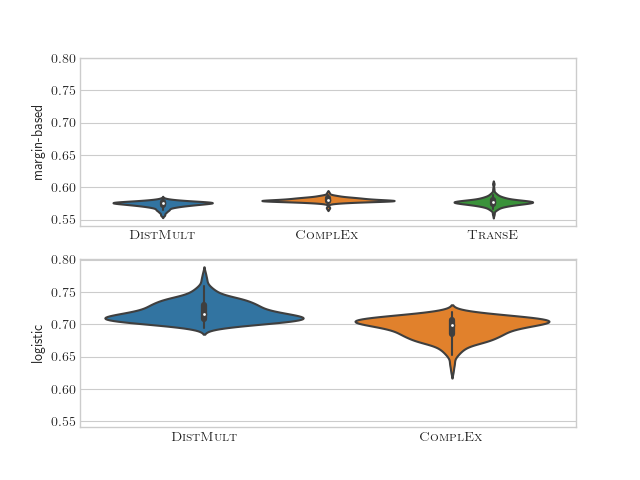

In [14]:
modes = ['pair', 'logistic']
paths = {
    'logistic': 'logistic-ensemble-relation-finetune-distmult-150-complex-200-2018-05-05-12-51-30-776',
    'pair': 'pair-ensemble-relation-finetune-distmult-150-complex-200-transe-150-l1-2018-05-05-08-54-43-961'
}
hps = ['margin', 'k', 'negatives', 'alpha']
names = ['DISTMULT', 'ComplEx', 'TransE']
name2label = {
    'DISTMULT': r'\textsc{DistMult}',
    'ComplEx': r'\textsc{ComplEx}',
    'TransE': r'\textsc{TransE}',
}
hp2label = {
    'margin': r'$\gamma$',
    'k': r'$h$',
    'negatives': r'$\eta$',
    'alpha': r'$\alpha$'
}
mode2label = {
    'logistic': 'logistic',
    'pair': 'margin-based'
}

fig, axes = plt.subplots(len(modes), 1, sharey=True)
fig.subplots_adjust(hspace=0.2)
sns.set_style("whitegrid")
sns.color_palette('muted')
col = 0
row = 0
for mode in modes:
    path = './models/fb15k-237/ensemble/weight-smaller-alpha-best/{}/parameters/weights'.format(paths[mode])
    df = pd.read_csv(path, header=None, names=['DISTMULT', 'ComplEx', 'TransE'])
    df = df.stack().to_frame().reset_index().drop('level_0', axis=1)
    df.columns = ['name', 'weight']
    sns.violinplot(data=df, x='name', y='weight', ax=axes[row], inner='box')
    # mode label
    axes[row].set_ylabel(mode2label[mode])
    axes[row].set_xlabel('')
    axes[row].set_xticklabels([name2label[name.get_text()] for name in axes[row].get_xticklabels()])
    row += 1
    
plt.savefig('img/ensemble-weights.eps', format='eps', dpi=1000)